In [224]:
from __future__ import print_function
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sp
from scipy.stats import norm
from scipy.stats import gamma
%matplotlib inline

In [225]:
df = pd.read_csv('./../data/clean_data.csv')

In [226]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [227]:
df['type'].value_counts()

tx         973640
call       492595
create      27726
suicide       318
Name: type, dtype: int64

In [228]:
df['newContract'].value_counts()

0    1489351
1       4928
Name: newContract, dtype: int64

In [229]:
for col in df.columns:
    print(col, df[col].isnull().sum())

_id_t 0
accountNonce 0
amount 0
blockHash 0
block_id 0
gasLimit_t 0
gasUsed_t 0
hash_t 0
newContract 0
parentHash_t 0
price 0
recipient 0
sender 0
time_t 0
type 0
_id_b 0
blockTime 0
coinbase 0
difficulty 0
extra 0
gasLimit_b 0
gasUsed_b 0
hash_b 0
mixDigest 1494279
nonce 0
number 0
parentHash_b 0
reward 0
root 0
size 0
time_b 0
totalFee 0
txHash 0
tx_count 0
uncleHash 0
uncle_count 0
price_gwei 0
amount_gwei 0
gasShare 0
gweiPaid 0
gweiPaid_b 0
gweiShare 2
free_t 0
day 0
hour 0
dayofweek 0


In [230]:
df.drop('mixDigest', axis=1, inplace=True)

In [231]:
df.dropna(inplace=True)

In [232]:
df.shape

(1494277, 45)

In [233]:
# drop cases where gasUsed_t is zero since no gas was used
print('exclude {} rows with zero gas used'.format(df[df['gasUsed_t'] == 0].values.shape[0]))

exclude 89799 rows with zero gas used


In [234]:
df = df[df['gasUsed_t'] != 0]

## Generate new columns with average block info
### Take average values over two time horizons
- 6 blocks (~1 min) -> represents the current state (short frequency view)
- 60 blocks (~10 min) -> represents the long term view

In [235]:
df['txcnt_second'] = df['tx_count'].values / df['blockTime'].values
df['avg_gasUsed_t_perblock'] = df.groupby('block_id')['gasUsed_t'].transform('mean')
df['avg_price_perblock'] = df.groupby('block_id')['price_gwei'].transform('mean')

In [236]:
def rolling_avg(window_size):
    
    price = df[['block_id', 'avg_price_perblock']].drop_duplicates().sort_values(
                        'block_id', ascending=True)
    
    gasUsed_t = df[['block_id', 'avg_gasUsed_t_perblock']].drop_duplicates().sort_values(
                            'block_id', ascending=True)
    
    txcnt_second = df[['block_id', 'txcnt_second']].drop_duplicates().sort_values(
                                'block_id', ascending=True)
    
    tx_count = df[['block_id', 'tx_count']].drop_duplicates().sort_values(
                            'block_id', ascending=True)
    
    gasUsed_b = df[['block_id', 'gasUsed_b']].drop_duplicates().sort_values(
                            'block_id', ascending=True)
    
    uncle_count = df[['block_id', 'uncle_count']].drop_duplicates().sort_values(
                                'block_id', ascending=True)
    
    difficulty = df[['block_id', 'difficulty']].drop_duplicates().sort_values(
                                'block_id', ascending=True)
    
    blocktime = df[['block_id', 'blockTime']].drop_duplicates().sort_values(
                             'block_id', ascending=True)
    
    # create new pandas dataframe with average values
    rolling_avg = pd.DataFrame()
    
    # calculate rolling averages 
    rolling_avg['avg_blocktime'] = blocktime['blockTime'].rolling(window=window_size).mean()
    rolling_avg['avg_gasUsed_b'] = gasUsed_b['gasUsed_b'].rolling(window=window_size).mean()
    rolling_avg['avg_tx_count'] = tx_count['tx_count'].rolling(window=window_size).mean()
    rolling_avg['avg_uncle_count'] = uncle_count['uncle_count'].rolling(window=window_size).mean()
    rolling_avg['avg_difficulty'] = difficulty['difficulty'].rolling(window=window_size).mean()
    rolling_avg['avg_txcnt_second'] = txcnt_second['txcnt_second'].rolling(window=window_size).mean()
    rolling_avg['avg_gasUsed_t'] = gasUsed_t['avg_gasUsed_t_perblock'].rolling(window=window_size).mean()
    rolling_avg['avg_price'] = price['avg_price_perblock'].rolling(window=window_size).mean()
    
    # insert blockids to merge on
    rolling_avg['blockids'] = df['block_id'].drop_duplicates().sort_values(ascending=True)
    
    return rolling_avg

In [237]:
num_blocks = [6, 60]
for num in num_blocks:
    df_rolling_avg = rolling_avg(num)
    df_rolling_avg.to_csv('./../data/block_avg_{}.csv'.format(num))

In [238]:
df_rolling_avg_6 = rolling_avg(6)

In [239]:
df_rolling_avg_60 = rolling_avg(60)

## Merge data with new columns

In [240]:
merged1 = pd.merge(df, df_rolling_avg_6, left_on='block_id', right_on='blockids')

In [241]:
merged2 = pd.merge(merged1, df_rolling_avg_60, left_on='block_id', right_on='blockids', suffixes=('_6', '_60'))

In [242]:
merged2.columns

Index([u'_id_t', u'accountNonce', u'amount', u'blockHash', u'block_id',
       u'gasLimit_t', u'gasUsed_t', u'hash_t', u'newContract', u'parentHash_t',
       u'price', u'recipient', u'sender', u'time_t', u'type', u'_id_b',
       u'blockTime', u'coinbase', u'difficulty', u'extra', u'gasLimit_b',
       u'gasUsed_b', u'hash_b', u'nonce', u'number', u'parentHash_b',
       u'reward', u'root', u'size', u'time_b', u'totalFee', u'txHash',
       u'tx_count', u'uncleHash', u'uncle_count', u'price_gwei',
       u'amount_gwei', u'gasShare', u'gweiPaid', u'gweiPaid_b', u'gweiShare',
       u'free_t', u'day', u'hour', u'dayofweek', u'txcnt_second',
       u'avg_gasUsed_t_perblock', u'avg_price_perblock', u'avg_blocktime_6',
       u'avg_gasUsed_b_6', u'avg_tx_count_6', u'avg_uncle_count_6',
       u'avg_difficulty_6', u'avg_txcnt_second_6', u'avg_gasUsed_t_6',
       u'avg_price_6', u'blockids_6', u'avg_blocktime_60', u'avg_gasUsed_b_60',
       u'avg_tx_count_60', u'avg_uncle_count_60', u'avg_

In [ ]:
## L

# Create a label
- What are we predicting? 
- A hindsight estimate of what the price should be, given knowledge about previous blocks
- Develop a summary statistic about the distribution of prices over previous blocks
- Our target: the 25th percentile of the distribution (gweiShare / gasShare)

## Definitions
- gasUsed_t -> the amount of gas consumed on a transation
- gasUsed_b -> the amount of gas consumed in an entire block
- gweiPaid -> the total amount paid (Gwei) for a transaction (= gasUsed_t x price_gwei)
- gweiPaid_b -> the total amount paid in a block 
- gweiShare -> the fraction of gwei paid w.r.t. the entire block
- gasShare -> the fraction of gas consumed w.r.t. the entire block

## Define "miner value" – mv
- the fraction of prices per block and gas per block
- mv = gweiShare / gasShare 
- local parameter (per transaction)

## Define mu
- mu is a summary statistic of mv (global parameter)
- a measure of how likely a transaction is to be "picked up" by a miner for completion (risk factor)
- our target/goal is for mu to be the 25th percentile of mv (gweiShare / gasShare)
- mu = percentile(mv, 25) over the entire distribution of mv values
- we can tune this parameter to increase or decrease the desired percentile 
- it is a pre-emptive statistical calculation based on our hindsight knowledge

## The "price" predicted with hindsight 
- knowing mu, how do we obtain our hindsight recommendation?
- using our definition of mu, we solve an equation to obtain p (price)
- p = (mu x gweiPaid_b) / gasUsed_b
- this will serve as our label and thus recommendation for how much to pay per unit gas for a transation to successfully commence 
- it tells us what price we need to set in order to force mv for that bid to be mu

## Calculate miner value (mv) for every datapoint in our dataset
- price / gas or gweiShare / gasShare

In [243]:
merged2['mv'] = merged2.gweiShare / merged2.gasShare

In [244]:
merged2['mv'].isnull().sum()

0

In [245]:
merged2['mv'].describe()

count    1.404478e+06
mean     1.631380e+00
std      4.518241e+00
min      5.990722e-11
25%      7.329693e-01
50%      1.181439e+00
75%      1.911525e+00
max      4.233297e+03
Name: mv, dtype: float64

There are no zero values, but many values close to zero

In [246]:
merged2.groupby('block_id')['mv'].count().head(6)

block_id
4286251    258
4286252    241
4286253    208
4286254    107
4286255    189
4286256    192
Name: mv, dtype: int64

In [247]:
merged2.groupby('block_id')['mv'].count().mean()

96.3158688794404

There are only on average 96 samples in each block

In [248]:
print('max tx in block: {}, min tx in block: {}'.format(
       merged2.groupby('block_id')['mv'].count().max(),
       merged2.groupby('block_id')['mv'].count().min()))

max tx in block: 504, min tx in block: 1


So we create groupings of 6 blocks to increase sample size

## Compute the summary statistic mu
- given the distribution of mv values, fit a statistical model to the data
- use this fit model to compute the 25th percentile of the distribution

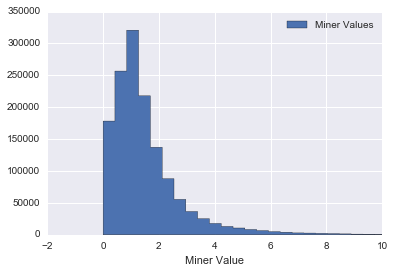

In [249]:
merged2['mv'].hist(bins=10000, label='Miner Values', histtype='stepfilled')
plt.xlim(-2, 10)
plt.xlabel('Miner Value')
plt.legend()

In [250]:
# compute mean, variance, standard deviation
mu_hat = np.mean(merged2['mv'])
sigma_sq_hat = np.var(merged2['mv'])
sigma_hat = np.std(merged2['mv'])
print("Sample Mean: {0:1.3f}".format(mu_hat))
print("Sample Variance: {0:1.3f}".format(sigma_sq_hat))
print("Sample Standard Dev: {0:1.3f}".format(sigma_hat))

Sample Mean: 1.631
Sample Variance: 20.414
Sample Standard Dev: 4.518


### Trying a Gaussian distribution

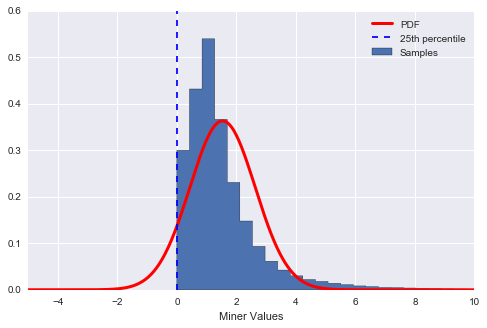

In [321]:
x = np.linspace(-10, 15, num=1000)
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

ax.hist(merged2['mv'], normed=True, bins=10000, histtype='stepfilled', label='Samples')
ax.plot(x, norm.pdf(x, mu_hat,sigma_hat), 'r-', lw=3, label='PDF')
ax.axvline(x=np.percentile(norm.pdf(x, mu_hat,sigma_hat), 25), linestyle='--', label='25th percentile')
ax.set_xlim(-5,10)
ax.set_xlabel('Miner Values')
ax.legend()

In [322]:
# compute 25th percentile
np.percentile(norm.pdf(x, mu_hat,sigma_hat), 25)

5.0170797135435324e-17

Set this value to mu

In [323]:
mu_normal = np.percentile(norm.pdf(x, mu_hat,sigma_hat), 25)

### Trying a Gamma distribution

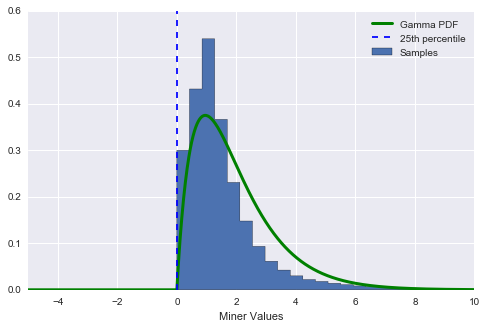

In [324]:
alpha = float(mu_hat ** 2) / sigma_sq_hat
beta = float(mu_hat) / sigma_sq_hat

x = np.linspace(-5, 10, num=1000)
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

ax.hist(merged2['mv'], normed=True, bins=10000, histtype='stepfilled', label='Samples')
ax.plot(x, gamma.pdf(x, alpha), 'g-', lw=3, label='Gamma PDF')
ax.axvline(x=np.percentile(gamma.pdf(x, alpha), 25), linestyle='--', label='25th percentile')
ax.set_xlim(-5,10)
ax.set_xlabel('Miner Values')
ax.legend()

In [325]:
# compute 25th percentile
np.percentile(gamma.pdf(x, alpha), 25)

0.0

The gamma distribution appears to fit the empirical data better but we get zero for the 25th percentile

# Compute the label, p, given mu
- knowing mu, how do we obtain our hindsight recommendation?
- using our definition of mu, we solve an equation to obtain p (price)
- p = (mu x gweiPaid_b) / gasUsed_b
- this will serve as our label and thus recommendation for how much to pay per unit gas for a transation to successfully commence 
- it tells us what price we need to set in order to force mv for that bid to be mu

In [336]:
mu_normal

5.0170797135435324e-17

In [337]:
merged2['p_label'] = mu_normal * (merged2.gweiPaid_b / merged2.gasUsed_b)

(-0.1, 1)

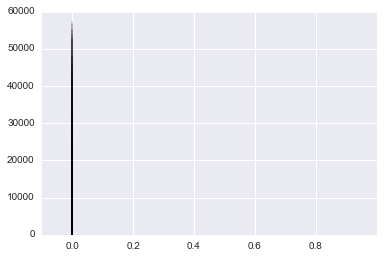

In [338]:
merged2['p_label'].hist(bins=3000)
plt.xlim(-0.1,1)

If mu is higher around 0.01 we get a normal distribution

## Write training set and labels to a csv file for modeling

In [333]:
merged2.columns

Index([u'_id_t', u'accountNonce', u'amount', u'blockHash', u'block_id',
       u'gasLimit_t', u'gasUsed_t', u'hash_t', u'newContract', u'parentHash_t',
       u'price', u'recipient', u'sender', u'time_t', u'type', u'_id_b',
       u'blockTime', u'coinbase', u'difficulty', u'extra', u'gasLimit_b',
       u'gasUsed_b', u'hash_b', u'nonce', u'number', u'parentHash_b',
       u'reward', u'root', u'size', u'time_b', u'totalFee', u'txHash',
       u'tx_count', u'uncleHash', u'uncle_count', u'price_gwei',
       u'amount_gwei', u'gasShare', u'gweiPaid', u'gweiPaid_b', u'gweiShare',
       u'free_t', u'day', u'hour', u'dayofweek', u'txcnt_second',
       u'avg_gasUsed_t_perblock', u'avg_price_perblock', u'avg_blocktime_6',
       u'avg_gasUsed_b_6', u'avg_tx_count_6', u'avg_uncle_count_6',
       u'avg_difficulty_6', u'avg_txcnt_second_6', u'avg_gasUsed_t_6',
       u'avg_price_6', u'blockids_6', u'avg_blocktime_60', u'avg_gasUsed_b_60',
       u'avg_tx_count_60', u'avg_uncle_count_60', u'avg_

In [334]:
# select candidate features for modeling
sel_cols = ['gasLimit_t',
           'gasUsed_t',
           'newContract',
           'blockTime',
           'difficulty',
           'gasLimit_b',
           'gasUsed_b',
           'reward',
           'size',
           'totalFee',
           'amount_gwei',
           'gasShare',
           'gweiPaid',
           'gweiPaid_b',
           'gweiShare',
           'free_t',
           'day',
           'hour',
           'dayofweek',
           'txcnt_second',
           'avg_blocktime_6',
           'avg_gasUsed_b_6',
           'avg_tx_count_6', 
           'avg_uncle_count_6',
           'avg_difficulty_6',
           'avg_txcnt_second_6',
           'avg_gasUsed_t_6',
           'avg_price_6', 
           'avg_blocktime_60',
           'avg_gasUsed_b_60',
           'avg_tx_count_60',
           'avg_uncle_count_60',
           'avg_difficulty_60',
           'avg_txcnt_second_60',
           'avg_gasUsed_t_60',
           'avg_price_60',
           'mv']

In [287]:
features = merged2[sel_cols]

In [288]:
features.to_csv('./../data/training.csv')

In [289]:
labels = merged2['p_label']

In [290]:
labels.to_csv('./../data/labels.csv')

### Model for first group of 6

In [291]:
# compute mean, variance, standard deviation
mu_hat = np.mean(samples)
sigma_sq_hat = np.var(samples)
sigma_hat = np.std(samples)
print("Sample Mean: {0:1.3f}".format(mu_hat))
print("Sample Variance: {0:1.3f}".format(sigma_sq_hat))
print("Sample Standard Dev: {0:1.3f}".format(sigma_hat))

Sample Mean: 1.535
Sample Variance: 1.206
Sample Standard Dev: 1.098


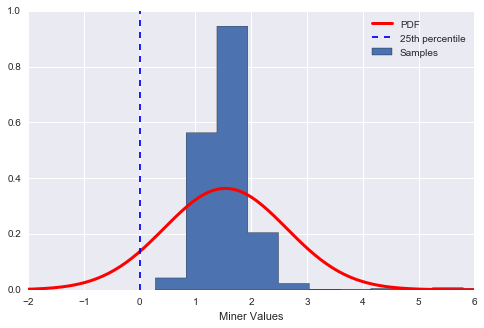

In [292]:
x = np.linspace(-5, 8, num=250)
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

ax.hist(samples, normed=True, bins=25, histtype='stepfilled', label='Samples')
ax.plot(x, norm.pdf(x, mu_hat,sigma_hat), 'r-', lw=3, label='PDF')
ax.axvline(x=np.percentile(norm.pdf(x, mu_hat,sigma_hat), 25), linestyle='--', label='25th percentile')
ax.set_xlim(-2,6)
ax.set_xlabel('Miner Values')
ax.legend()

In [293]:
# compute 25th percentile
np.percentile(norm.pdf(x, mu_hat,sigma_hat), 25)

1.7948041111385629e-05